Notebook for training a 3D U-Net for vestibular schwannoma segmentation. 

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import segmentation_models_3D as sm

In [33]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [34]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_DEPTH = 64
IMG_CHANNELS = 1
SEED = 42
random.seed(SEED)

Load the data. 

In [35]:
mris_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\mris_dataset_128.npy"
masks_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\masks_dataset_128.npy"


mris = np.load(mris_path)
masks = np.load(masks_path)



In [36]:
mris.shape

(242, 128, 128, 64)

In [37]:
masks.shape

(242, 128, 128, 64)

Normalise the data. 

In [38]:
def normalize_3d_image(img):
    return (img - img.min()) / (img.max() - img.min())


# def standardize_3d_image(img):
#     """
#     Standardize a 3D image using Z-score normalization.

#     Parameters:
#     - img: 3D numpy array representing the MRI image.

#     Returns:
#     - standardized_img: 3D numpy array representing the standardized MRI image.
#     """
#     mean = np.mean(img)
#     std = np.std(img)
#     standardized_img = (img - mean) / std
#     return standardized_img

In [39]:
print(np.min(mris))
print(np.max(mris))

-201.7803
4201.074


In [40]:
for i in range(mris.shape[0]): 
    mris[i] = normalize_3d_image(mris[i])

In [41]:
print(np.min(mris))
print(np.max(mris))

0.0
1.0


Split the data into training and test sets. 

In [42]:
# Create an array of indices corresponding to the original dataset
indices = np.arange(len(mris))

X_train, X_test, Y_train, Y_test, train_indices, test_indices = train_test_split(
    mris, masks, indices, test_size=0.20, shuffle=True, random_state=SEED
)

In [43]:


print(
    f"Training data\nDimensions: {X_train.shape}\nMax-value: {np.max(X_train)}\nMin-value: {np.min(X_train)}"
)
print(
    f"Test data\nDimensions: {X_test.shape}\nMax-value: {np.max(X_test)}\nMin-value: {np.min(X_test)}"
)


Training data
Dimensions: (193, 128, 128, 64)
Max-value: 1.0
Min-value: 0.0
Test data
Dimensions: (49, 128, 128, 64)
Max-value: 1.0
Min-value: 0.0


Build the model. 

In [44]:
model = sm.Unet(
    "resnet34",
    input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, IMG_CHANNELS),
    encoder_weights=None,
    activation="sigmoid",
)


dice_loss = sm.losses.DiceLoss()
bce_loss = sm.losses.BinaryCELoss()
total_loss = dice_loss + bce_loss


initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=total_loss,
    metrics=[sm.metrics.IOUScore()],
)


cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_iou_score", mode="max", patience=10, restore_best_weights=True
)


Train the model. 

In [45]:
history = model.fit(
    X_train, Y_train, epochs=100, batch_size=1, validation_split=0.20, callbacks=[cb]
)

Epoch 1/100
154/154 [==============================] - 87s 530ms/step - loss: 1.0154 - iou_score: 0.0233 - val_loss: 1.1257 - val_iou_score: 0.0047
Epoch 2/100
154/154 [==============================] - 80s 518ms/step - loss: 0.9284 - iou_score: 0.0447 - val_loss: 1.0213 - val_iou_score: 3.0259e-05
Epoch 3/100
154/154 [==============================] - 80s 521ms/step - loss: 0.5527 - iou_score: 0.3026 - val_loss: 0.7450 - val_iou_score: 0.1671
Epoch 4/100
154/154 [==============================] - 80s 522ms/step - loss: 0.2706 - iou_score: 0.6029 - val_loss: 0.3593 - val_iou_score: 0.5131
Epoch 5/100
154/154 [==============================] - 80s 521ms/step - loss: 0.2559 - iou_score: 0.6229 - val_loss: 0.3659 - val_iou_score: 0.5083
Epoch 6/100
154/154 [==============================] - 80s 522ms/step - loss: 0.2298 - iou_score: 0.6515 - val_loss: 0.2542 - val_iou_score: 0.6189
Epoch 7/100
154/154 [==============================] - 80s 522ms/step - loss: 0.1855 - iou_score: 0.7048 - v

Evaluate the model. 

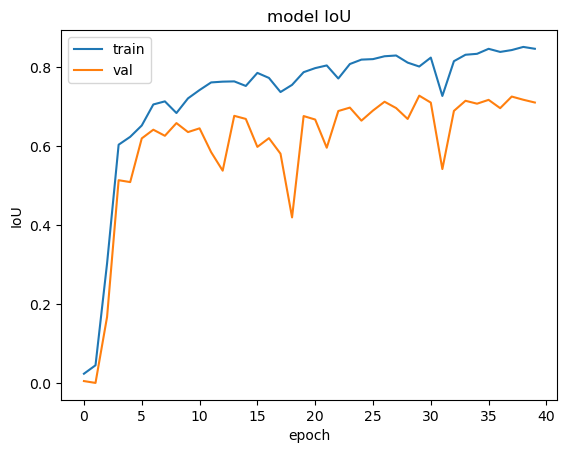

In [46]:
plt.plot(history.history["iou_score"])
plt.plot(history.history["val_iou_score"])
plt.title("model IoU")
plt.ylabel("IoU")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

Calculate the Dice score for each patient in the test set and average the results. 

In [47]:
def getScore(predictions, test_mask):
    intersection = np.logical_and(test_mask, predictions)
    dice_score = (np.sum(intersection) * 2) / (np.sum(predictions) + np.sum(test_mask))

    return dice_score


# Loop through each item, predict, and calculate scores

dice_scores = []

for i in range(X_test.shape[0]):
    single_item = np.expand_dims(X_test[i], axis=0)
    pred = model.predict(single_item)
    pred_t = (pred > 0.5).squeeze()  #  remove any singleton dimensions
    Y_test_single = Y_test[i]
    dice_score = getScore(pred_t, Y_test_single)

    dice_scores.append(dice_score)

# Calculate average scores

print(f"Dice for the whole test set: {round(np.average(dice_scores),3)}")

1/1 [==============================] - 0s 41ms/step
Dice for the whole test set: 0.816


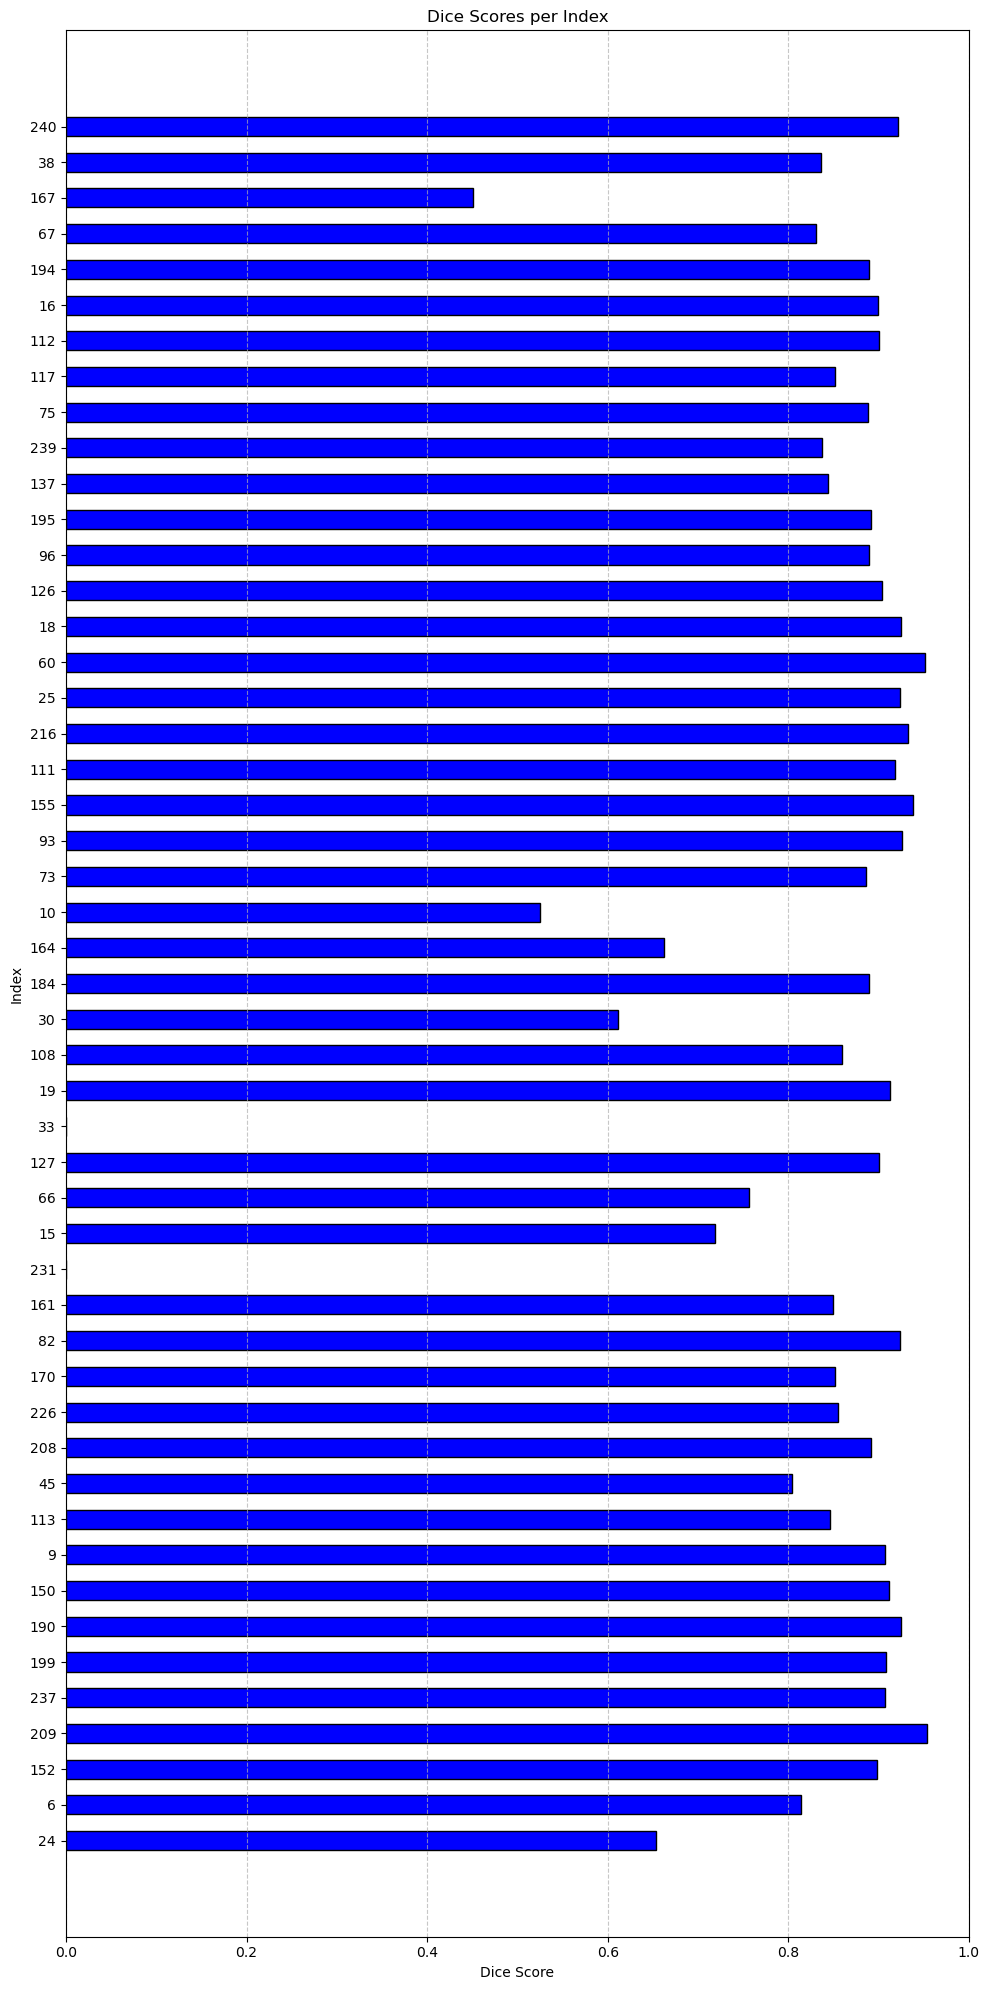

In [48]:

plt.figure(figsize=(10, 20))  
spacing = 1.5  # Adjust this to increase/decrease spacing
y_positions = np.arange(len(test_indices)) * spacing
plt.barh(y_positions, dice_scores, color="blue", edgecolor="black")
plt.ylabel("Index")
plt.xlabel("Dice Score")
plt.title("Dice Scores per Index")
plt.yticks(y_positions, test_indices)

plt.xlim(0, 1)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Calculate the 95th percentile Hausdorff distance. 

In [49]:
from scipy.ndimage import binary_dilation, distance_transform_edt

def get_surface_voxels(binary_mask):
    """
    Return a binary mask where 1s indicate the boundary voxels of the input mask.
    """
    dilated_mask = binary_dilation(binary_mask.astype(bool), structure=np.ones((3,3,3)))
    return dilated_mask ^ binary_mask.astype(bool)


def hausdorff95_distance(mask_true, mask_pred):
    """
    Compute the 95th percentile Hausdorff distance between two binary masks.
    """
    surface_mask_true = get_surface_voxels(mask_true)
    surface_mask_pred = get_surface_voxels(mask_pred)

    # For each surface voxel in mask_true, compute the distance to the nearest surface voxel in mask_pred.
    dt_mask_pred = distance_transform_edt(1 - surface_mask_pred)
    distances_a = dt_mask_pred[surface_mask_true]

    # For each surface voxel in mask_pred, compute the distance to the nearest surface voxel in mask_true.
    dt_mask_true = distance_transform_edt(1 - surface_mask_true)
    distances_b = dt_mask_true[surface_mask_pred]

    # Combine the two sets of distances and compute the 95th percentile.
    all_distances = np.hstack((distances_a, distances_b))
    
    return np.percentile(all_distances, 95)


In [53]:
hd95_scores = []

for i in range(X_test.shape[0]):
    single_item = np.expand_dims(X_test[i], axis=0)
    pred = model.predict(single_item)
    pred_t = (pred > 0.5).squeeze()  #  remove any singleton dimensions
    Y_test_single = Y_test[i]
    hd95 = hausdorff95_distance(Y_test[0], pred_t)

    hd95_scores.append(hd95)

# Calculate average scores

print(f"Avg. HD95 for the whole test set: {round(np.average(hd95_scores),3)}")


1/1 [==============================] - 0s 39ms/step
Avg. HD95 for the whole test set: 16.257


In [55]:
def plot_test_image_with_contours(index, X_test, Y_test):
    """
    Plots multiple slices of a 3D test image with annotated and predicted contours in the same figure.

    Parameters:
    - index: Index of the test image to plot.
    - X_test: Array of test images.
    - Y_test: Array of annotated masks/lines.
    """

    # Extract the specified test image and its corresponding masks
    img = X_test[index]
    annotated_mask = Y_test[index]

    # Predict the mask
    predicted_mask = model.predict(np.expand_dims(X_test[index, ...], axis=0))
    predicted_mask_t = predicted_mask > 0.5
    slice_indices = [
        i for i in range(img.shape[2]) if np.sum(annotated_mask[:, :, i]) > 0
    ]

    num_slices = len(slice_indices)
    plt.figure(figsize=(5, 5 * num_slices))

    for i, idx in enumerate(slice_indices):
        plt.subplot(num_slices, 1, i + 1)  # Create a subplot for each slice

        # Display the test image slice
        plt.imshow(img[:, :, idx], cmap="gray")

        # Display the annotated contour (in green color) for the slice
        plt.contour(annotated_mask[:, :, idx], colors="g", linewidths=0.5)

        # Display the predicted contour (in red color) for the slice
        plt.contour(
            predicted_mask_t[0, :, :, idx, 0], colors="r", linewidths=0.5
        )  

        plt.title(f"Slice {idx} with Annotated (Green) and Predicted (Red) Contours")
        plt.axis("off")

    plt.tight_layout()
    plt.show()




1/1 [==============================] - 0s 44ms/step


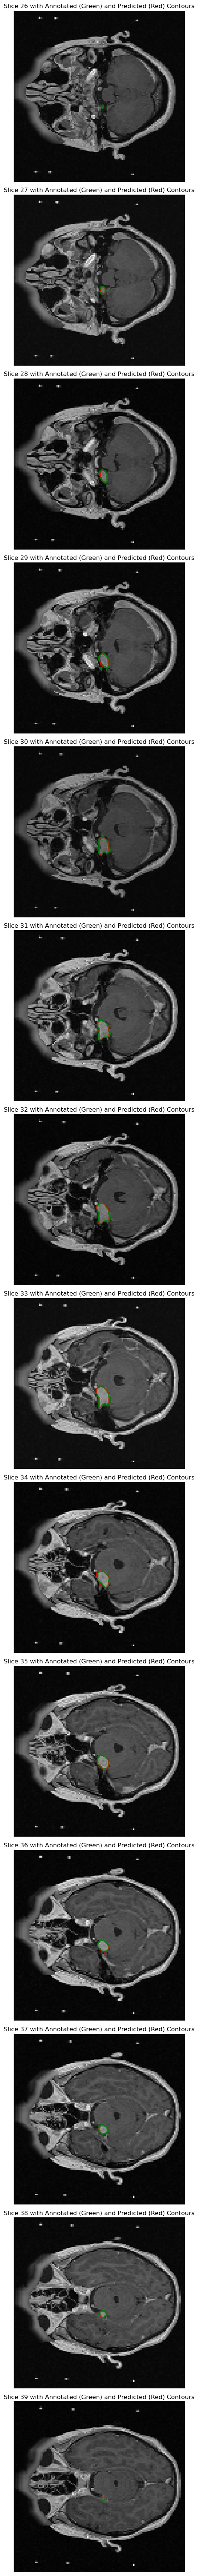

In [56]:
plot_test_image_with_contours(-1, X_test, Y_test)
